In [1]:
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv(
            "data/code_challenge_dataset.csv",
            encoding='latin1',
            on_bad_lines='skip',
            header=0,
            names=["timestamp", "session_id", "event_name", "group_id", "step_name"]
        )

In [32]:
# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data["timestamp"], format="mixed", errors="coerce")
data.sort_values(["session_id", "timestamp"], inplace=True)

In [19]:
print("\n--- Basic Data Overview ---")
print(data.info())


--- Basic Data Overview ---
<class 'pandas.core.frame.DataFrame'>
Index: 71831 entries, 0 to 71830
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   timestamp         71831 non-null  object
 1   session_id        71831 non-null  int64 
 2   event_name        71831 non-null  object
 3   group_id          71831 non-null  object
 4   step_name         71831 non-null  object
 5   action_type       71808 non-null  object
 6   group_id_encoded  71831 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.4+ MB
None


In [25]:
print("\n--- Summary Statistics ---")
print(data.describe())


--- Summary Statistics ---
         session_id  group_id_encoded
count  71831.000000      71831.000000
mean    5945.611616        466.455207
std     4019.999280        805.054797
min        1.000000          1.000000
25%     2402.000000         14.000000
50%     5513.000000        105.000000
75%     9451.000000        336.000000
max    13347.000000       3512.000000


In [23]:
# No null values in the data
data.isna().any()

timestamp           False
session_id          False
event_name          False
group_id            False
step_name           False
action_type          True
group_id_encoded    False
dtype: bool

In [26]:
#There are 4248 sessions present in the dataset
data.session_id.nunique()

4248

In [8]:
data.timestamp.min(), data.timestamp.max()

('2024-05-14 12:38:28+05:00', '2024-06-01 16:04:34+05:00')

<Axes: xlabel='step_name'>

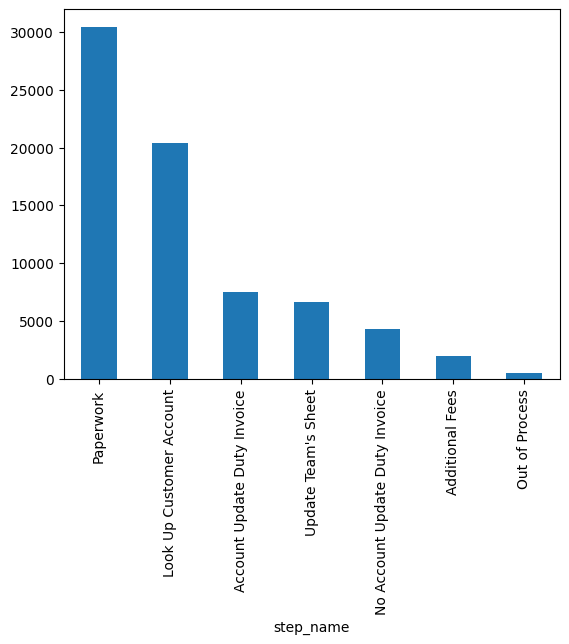

In [27]:
# Distribution of Step_names
data.step_name.value_counts().plot(kind='bar')
# Labels are imbalanced

In [7]:
def extract_action_type(event_name: str):
    """
    Matches any word (optionally containing '*') before a colon.
    Keeps '*' if present so "Action*" is different from "Action".
    Examples:
      "Write: AVPageView ..." -> "Write"
      "Action*: IBBR - ..."   -> "Action*"
    """
    if not isinstance(event_name, str):
        return None
    
    m = re.match(r"\s*([\w\*]+)\s*:", event_name, re.IGNORECASE)
    if m:
        word = m.group(1)
        return word[0].upper() + word[1:]
    
    return None

In [8]:
data["action_type"] = data.event_name.apply(extract_action_type)

In [17]:
data.head()

,timestamp,session_id,event_name,group_id,step_name,action_type
0,2024-05-14 12:38:28+05:00,1,Write: AVPageView in Acrobat Reader,b2243b00f9fe892f77c7aaf8c7001763b3b54311,Paperwork,Write
1,2024-05-14 12:38:30+05:00,1,Write: AVPageView in Acrobat Reader,1b39a3536438baaeb8bd04fc31062d5f133de643,Paperwork,Write
2,2024-05-14 12:38:32+05:00,1,Write: 4 4561 in Acrobat Reader,0cc8b8b149e6eff4cfc0bbb1aba3698bc19c8a7e,Paperwork,Write
3,2024-05-14 12:38:34+05:00,1,Read: 4695744561 . A543 . in dpdhl.sharepoint,4d5fae32c4dc0ab1539c2de14e5a2b1bbfe65bf7,Paperwork,Read
4,2024-05-14 12:38:42+05:00,1,Write: C:\Users\sharlow\OneDrive - DPDHL\Deskt...,ff299ed30f74398362257eeba6e0c38dee1ecabe,Paperwork,Write


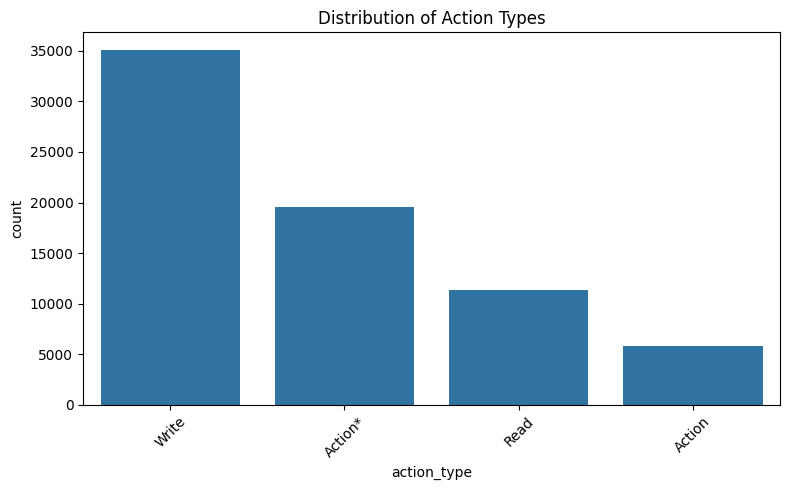

In [29]:
# ==============================
# 4. Action Type Distribution
# ==============================
plt.figure(figsize=(8,5))
sns.countplot(x='action_type', data=data, order=data['action_type'].value_counts().index)
plt.title('Distribution of Action Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [46]:
data.event_name.head(20)

0                   Write: AVPageView in Acrobat Reader
1                   Write: AVPageView in Acrobat Reader
2                       Write: 4 4561 in Acrobat Reader
3         Read: 4695744561 . A543 . in dpdhl.sharepoint
4     Write: C:\Users\sharlow\OneDrive - DPDHL\Deskt...
5                                     Read: D5 in Excel
6     Write: IBBR - IBS Customer Master File Inquiry...
7     Action*: IBBR - IBS Customer Master File Inqui...
9                 Action*: 751040500 in ibbr-global.dhl
8     Read: IBBR - IBS Customer Master File Inquiry ...
11    Action*: C:\Users\sharlow\OneDrive - DPDHL\Des...
10    Write: C:\Users\sharlow\OneDrive - DPDHL\Deskt...
12    Action*: C:\Users\sharlow\OneDrive - DPDHL\Des...
13    Write: C:\Users\sharlow\OneDrive - DPDHL\Deskt...
14    Write: C:\Users\sharlow\OneDrive - DPDHL\Deskt...
15                  Write: AVPageView in Acrobat Reader
16                  Write: AVPageView in Acrobat Reader
17                      Write: 5 4250 in Acrobat

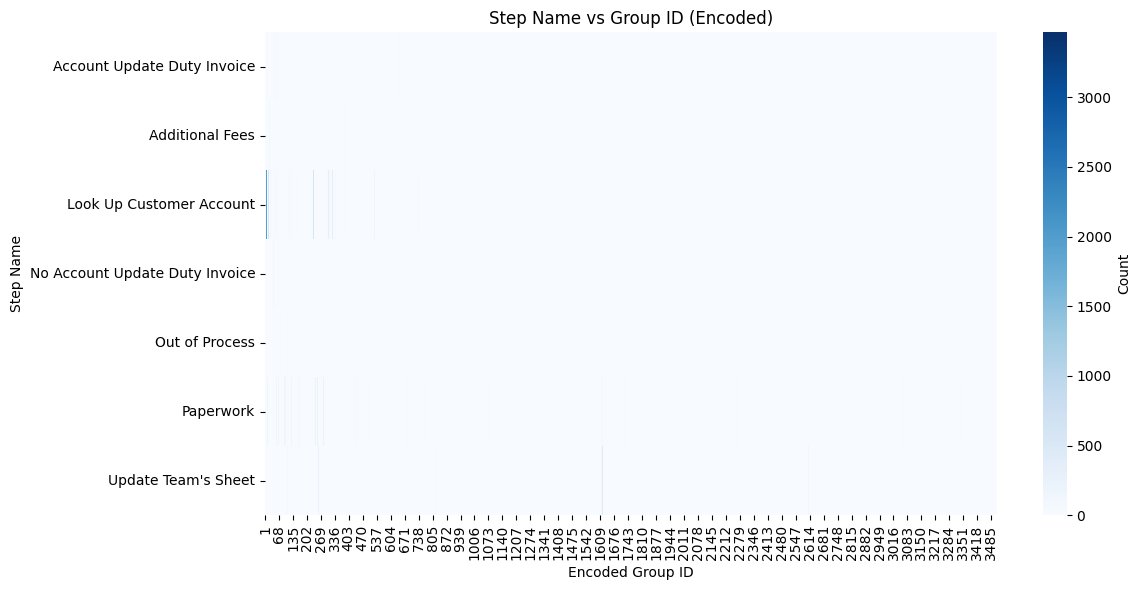

In [42]:
# ==============================
# 6. Correlation between step_name and group_id
# ==============================
# ==============================
# Encode group_ids for visualization
# ==============================
group_id_mapping = {gid: idx for idx, gid in enumerate(data['group_id'].unique(), start=1)}
data['group_id_encoded'] = data['group_id'].map(group_id_mapping)

# Cross-tab with encoded IDs
cross_tab = pd.crosstab(data['step_name'], data['group_id_encoded'])

plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, cmap="Blues", cbar_kws={'label': 'Count'}, annot=False)
plt.title('Step Name vs Group ID (Encoded)')
plt.xlabel('Encoded Group ID')
plt.ylabel('Step Name')
plt.tight_layout()
plt.show()


In [9]:
session_sequences = data.groupby('session_id')['action_type'].apply(list)
print("\n--- Example Event Sequences ---")
print(session_sequences.head())


--- Example Event Sequences ---
session_id
1    [Write, Write, Write, Read, Write, Read, Write...
2    [Write, Write, Write, Write, Write, Read, Writ...
3    [Write, Write, Write, Action*, Write, Action, ...
4    [Write, Write, Write, Action*, Write, Action, ...
5    [Write, Write, Write, Action*, Write, Read, Ac...
Name: action_type, dtype: object


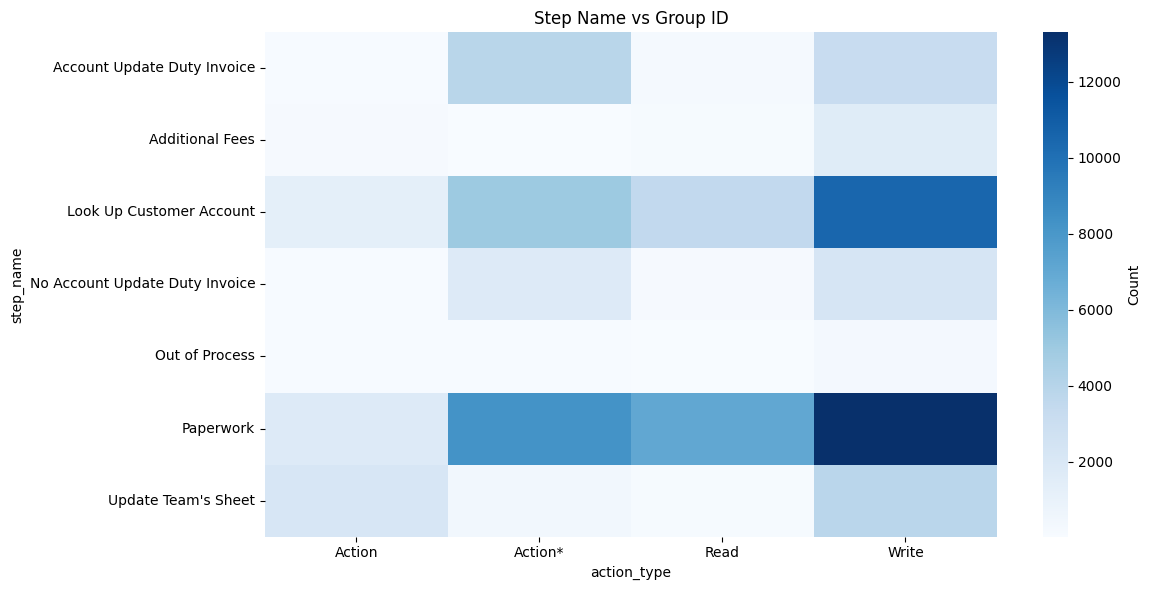

In [10]:
cross_tab = pd.crosstab(data['step_name'], data['action_type'])
plt.figure(figsize=(12,6))
sns.heatmap(cross_tab, cmap="Blues", cbar_kws={'label': 'Count'})
plt.title('Step Name vs Group ID')
plt.tight_layout()
plt.show()

In [28]:
data[data.step_name=="Out of Process"].action_type.value_counts()

action_type
Write      292
Action*    122
Action      96
Read        24
Name: count, dtype: int64

In [43]:
data = add_session_duration(data)

In [38]:
def add_session_duration(df: pd.DataFrame) -> pd.DataFrame:
    grp = df.groupby("session_id")["timestamp"]
    duration = grp.transform(lambda x: (x.max() - x.min()).total_seconds() if x.notna().all() else np.nan)
    df["session_duration"] = duration.astype(float)
    return df

In [44]:
data.session_duration.describe()

count    71831.000000
mean        70.380660
std         52.178882
min          0.000000
25%         37.000000
50%         54.001000
75%         85.000000
max        410.000000
Name: session_duration, dtype: float64

In [5]:
session_stats = data.groupby('session_id').agg({
    'timestamp': ['min', 'max', 'count'],
    'group_id': pd.Series.nunique,
    'step_name': pd.Series.nunique
})
session_stats.columns = ['start_time', 'end_time', 'event_count', 'unique_group_ids', 'unique_step_names']
session_stats['session_duration_sec'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds()

print("\n--- Session Statistics ---")
print(session_stats.describe())

TypeError: unsupported operand type(s) for -: 'str' and 'str'